<h1> AI Model that accurately predicts the outcome of any champion matchup in lane </h1>

<h2> Webscrape </h2>

<h4>Webscraping for list of all availible champions, respective winrates, pick rates, and ban rates. </h4>

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

response = requests.get('https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/v1/champions/')
response.raise_for_status()
soup = BeautifulSoup(response.text, 'html.parser')
links = []
for a_tag in soup.find_all('a', href=True):
    href = a_tag['href']
    if href.endswith('.json') and not href =='-1.json':
        links.append(f"https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/v1/champions/{href}")

def json_extract(obj, key):
    arr = []

    def extract(obj, arr, key):
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k == key:
                    arr.append(v)
                elif isinstance(v, (dict,list)):
                    extract(v, arr, key)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)

        return arr
    
    values = extract(obj, arr, key)
    return values

champion_names = []
champion_ids = []

for url in links:
    champion_json = requests.get(url).json()
    
    id = json_extract(champion_json, 'id')
    name = json_extract(champion_json, 'name')
    champion_names.append(name[0])
    champion_ids.append(id[0])

championId_dict = dict(map(lambda i, j: (int(i), j), champion_ids, champion_names))

In [2]:
championId_dict #list of all champion names scraped from community dragon

{1: 'Annie',
 10: 'Kayle',
 101: 'Xerath',
 102: 'Shyvana',
 103: 'Ahri',
 104: 'Graves',
 105: 'Fizz',
 106: 'Volibear',
 107: 'Rengar',
 11: 'Master Yi',
 110: 'Varus',
 111: 'Nautilus',
 112: 'Viktor',
 113: 'Sejuani',
 114: 'Fiora',
 115: 'Ziggs',
 117: 'Lulu',
 119: 'Draven',
 12: 'Alistar',
 120: 'Hecarim',
 121: "Kha'Zix",
 122: 'Darius',
 126: 'Jayce',
 127: 'Lissandra',
 13: 'Ryze',
 131: 'Diana',
 133: 'Quinn',
 134: 'Syndra',
 136: 'Aurelion Sol',
 14: 'Sion',
 141: 'Kayn',
 142: 'Zoe',
 143: 'Zyra',
 145: "Kai'Sa",
 147: 'Seraphine',
 15: 'Sivir',
 150: 'Gnar',
 154: 'Zac',
 157: 'Yasuo',
 16: 'Soraka',
 161: "Vel'Koz",
 163: 'Taliyah',
 164: 'Camille',
 166: 'Akshan',
 17: 'Teemo',
 18: 'Tristana',
 19: 'Warwick',
 2: 'Olaf',
 20: 'Nunu & Willump',
 200: "Bel'Veth",
 201: 'Braum',
 202: 'Jhin',
 203: 'Kindred',
 21: 'Miss Fortune',
 22: 'Ashe',
 221: 'Zeri',
 222: 'Jinx',
 223: 'Tahm Kench',
 23: 'Tryndamere',
 233: 'Briar',
 234: 'Viego',
 235: 'Senna',
 236: 'Lucian',
 2

In [3]:
import re
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

response = requests.get('https://u.gg/lol/champions', headers=headers)
response.raise_for_status()  # Check if the request was successful
soup = BeautifulSoup(response.text, 'html.parser')
baseURL = "https://u.gg/"

champContainer = soup.find('div', class_='champion-home-page')
champion_data = []
if champContainer:
    links = champContainer.find_all('a')

    for link in links:
        url = baseURL + link['href']
        resp = requests.get(url, headers=headers)
        if resp.status_code == 200:
            html = resp.text
            soup1 = BeautifulSoup(html, 'html.parser')
            rankingStats = soup1.find('div', class_='champion-ranking-stats-normal')
            if rankingStats:
                text = rankingStats.text.strip()
                tier_pattern = r"([A-S]\+?Tier)"
                redTier_pattern = r"([A-S]\+)"
                win_rate_pattern = r"(\d+(\.\d+)?%)Win Rate"
                rank_pattern = r"(\d+ / \d+)Rank"
                pick_rate_pattern = r"(\d+\.\d+%)Pick Rate"
                ban_rate_pattern = r"(\d+\.\d+%)Ban Rate"
                matches_pattern = r"(\d+,?\d*,?\d*)Matches"
                
                # Apply patterns
                tier = re.search(tier_pattern, text).group(1)
                win_rate = re.search(win_rate_pattern, text).group(1)
                rank = re.search(rank_pattern, text).group(1)
                pick_rate = re.search(pick_rate_pattern, text).group(1)
                ban_rate = re.search(ban_rate_pattern, text).group(1)
                matches = re.search(matches_pattern, text).group(1)

                numbers = rank.split('/')

                # Strip whitespace and convert to integers
                numerator = int(numbers[0].strip())
                denominator = int(numbers[1].strip())

                # Perform division
                rank = f"{((numerator / denominator)*100):.2f}%"

                name = soup1.find('span', class_='champion-name').text.strip()
                if name == 'Red Kayn':
                    name = 'Kayn'

                champion_data.append({
                'name' : name,
                'tier': tier,
                'win_rate': win_rate,
                'rank': rank,
                'pick_rate': pick_rate,
                'ban_rate': ban_rate,
                'matches': matches
                })

In [4]:
champion_data_df = pd.DataFrame(champion_data)
champion_data_df #Data of all champions scraped from u.gg

,name,tier,win_rate,rank,pick_rate,ban_rate,matches
0,Aatrox,ATier,49.97%,66.10%,11.4%,16.2%,"300,655"
1,Ahri,CTier,49.66%,67.24%,8.9%,10.1%,"224,349"
2,Akali,DTier,49.02%,81.03%,4.8%,11.9%,"126,152"
3,Akshan,S+Tier,52.49%,6.90%,2.7%,8.5%,"71,426"
4,Alistar,STier,50.77%,27.27%,6.3%,2.3%,"166,081"
...,...,...,...,...,...,...,...
162,Zeri,CTier,49.72%,59.26%,12.0%,4.6%,"300,497"
163,Ziggs,DTier,47.88%,93.10%,1.4%,0.3%,"35,191"
164,Zilean,ATier,50.25%,40.91%,2.3%,0.7%,"57,974"
165,Zoe,ATier,50.91%,32.76%,2.4%,1.2%,"64,511"


In [416]:
champion_data_df.to_csv('champion_data_df.csv')

<h2> Data Collection </h2>

<h4> Helper Functions </h4>

In [11]:
def merge_champion_stats(all_match_df, champion_data_df):
    all_matchData_df = all_match_df.copy()

    pattern = re.compile(r'^(redTeam|blueTeam)$')
    for index, row in all_match_df.iterrows():
        for col in all_match_df.columns:
            if pattern.match(col):
                champion_name = all_match_df.loc[index, col]
                stats = champion_data_df[champion_data_df['name'] == champion_name]
                if not stats.empty:
                    for stat_col in champion_data_df.columns:
                        if stat_col != 'name' and stat_col != 'matches' :
                            all_matchData_df.loc[index, f"{col}_{stat_col}"] = stats[stat_col].values[0]

    all_matchData_df[f'redTeam_win_rate'] = all_matchData_df[f'redTeam_win_rate'].str.rstrip('%').astype(float)
    all_matchData_df[f'redTeam_pick_rate'] = all_matchData_df[f'redTeam_pick_rate'].str.rstrip('%').astype(float)
    all_matchData_df[f'redTeam_ban_rate'] = all_matchData_df[f'redTeam_ban_rate'].str.rstrip('%').astype(float)
    all_matchData_df[f'redTeam_rank'] = all_matchData_df[f'redTeam_rank'].str.rstrip('%').astype(float)

    all_matchData_df[f'blueTeam_win_rate'] = all_matchData_df[f'blueTeam_win_rate'].str.rstrip('%').astype(float)
    all_matchData_df[f'blueTeam_pick_rate'] = all_matchData_df[f'blueTeam_pick_rate'].str.rstrip('%').astype(float)
    all_matchData_df[f'blueTeam_ban_rate'] = all_matchData_df[f'blueTeam_ban_rate'].str.rstrip('%').astype(float)
    all_matchData_df[f'blueTeam_rank'] = all_matchData_df[f'blueTeam_rank'].str.rstrip('%').astype(float)

    return all_matchData_df

<h4> importing data collected from databook.ipynb </h4>

In [363]:
tester_df = pd.read_csv('dfv3.csv').copy()
tester_df = tester_df.drop(columns='Unnamed: 0')
tester_df

,outcome,redTeam,blueTeam,Role
0,1,85,77,TOP
1,1,107,76,JUNGLE
2,1,238,3,MIDDLE
3,1,145,81,BOTTOM
4,1,497,147,UTILITY
...,...,...,...,...
37990,0,875,266,TOP
37991,0,19,30,JUNGLE
37992,0,103,18,MIDDLE
37993,0,222,22,BOTTOM


In [364]:
tester_df.reset_index(drop=True, inplace=True)
# Specify columns to replace
columns_to_replace = ['redTeam', 'blueTeam']

# Create a dictionary for specific columns
replacement_dict = {col: championId_dict for col in columns_to_replace}

# Replace values in specific columns
tester_df.replace(replacement_dict, inplace=True)
#all_match_df = all_match_df.replace(championId_dict)

<h4> Combines list of champions played and their stats </h4>

In [365]:
pd.options.display.max_columns = 100
tester_df = merge_champion_stats(tester_df, champion_data_df)

In [366]:
tester_df

,outcome,redTeam,blueTeam,Role,redTeam_tier,redTeam_win_rate,redTeam_rank,redTeam_pick_rate,redTeam_ban_rate,blueTeam_tier,blueTeam_win_rate,blueTeam_rank,blueTeam_pick_rate,blueTeam_ban_rate
0,1,Kennen,Udyr,TOP,ATier,50.69,38.98,2.4,1.6,STier,51.88,5.88,3.4,2.4
1,1,Rengar,Nidalee,JUNGLE,DTier,48.61,88.24,2.7,5.4,S+Tier,50.17,50.98,9.2,12.7
2,1,Zed,Galio,MIDDLE,DTier,48.80,87.93,7.0,18.7,S+Tier,52.45,8.62,3.8,1.5
3,1,Kai'Sa,Ezreal,BOTTOM,S+Tier,50.81,29.63,33.7,12.8,DTier,49.56,74.07,25.2,15.1
4,1,Rakan,Seraphine,UTILITY,ATier,50.11,45.45,5.0,0.8,ATier,50.63,34.09,4.7,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37990,0,Sett,Aatrox,TOP,S+Tier,51.06,18.64,6.9,2.9,ATier,49.97,66.10,11.4,16.2
37991,0,Warwick,Karthus,JUNGLE,ATier,51.17,15.69,2.7,1.2,DTier,49.06,76.47,3.4,13.1
37992,0,Ahri,Tristana,MIDDLE,CTier,49.66,67.24,8.9,10.1,S+Tier,50.71,41.38,11.3,20.2
37993,0,Jinx,Ashe,BOTTOM,S+Tier,51.36,22.22,14.9,5.9,S+Tier,51.05,25.93,10.5,13.6


-----

----

<h2> AI Model Training/Testing </h2>

<h4> Preprocessing Data </h4>

In [392]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

tiers = ['S+Tier', 'STier', 'ATier', 'BTier', 'CTier', 'DTier']

tier_label_encoder = LabelEncoder()

tier_label_encoder.fit(tiers)

LabelEncoder()

In [393]:
all_champions = []
for champ in championId_dict.values():
    all_champions.append(champ)
label_encoder = LabelEncoder()
label_encoder.fit(all_champions)

all_champions = label_encoder.transform(all_champions)
# Fit and transform the data
tester_df['redTeam'] = label_encoder.transform(tester_df['redTeam'])
tester_df['redTeam_tier'] = tier_label_encoder.transform(tester_df['redTeam_tier'])

tester_df['blueTeam'] = label_encoder.transform(tester_df['blueTeam'])
tester_df['blueTeam_tier'] = tier_label_encoder.transform(tester_df['blueTeam_tier'])

#tester_df['Role'] = onehot_encoder.transform(tester_df[['Role']])

x = tester_df.drop(columns=['outcome', 'Role'])
y = tester_df['outcome']

In [396]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Concatenate, Input
from tensorflow.keras.models import Model

input_red = Input(shape=(1,), dtype=tf.int32)
input_blue = Input(shape=(1,), dtype=tf.int32)
input_features = Input(shape=(X_train.shape[1] - 4,))

#unique_champions = np.unique(tester_df[['redTeam', 'blueTeam']].values.flatten())
unique_champions = np.unique(all_champions)
champion_mapping = {champ: i for i, champ in enumerate(unique_champions)}

In [398]:
X_train['redTeam_mapped'] = X_train['redTeam'].map(champion_mapping)
X_train['blueTeam_mapped'] = X_train['blueTeam'].map(champion_mapping)

X_test['redTeam_mapped'] = X_test['redTeam'].map(champion_mapping)
X_test['blueTeam_mapped'] = X_test['blueTeam'].map(champion_mapping)

In [400]:
embedding_dim = 8
embed_red = Embedding(input_dim=len(unique_champions), output_dim=embedding_dim, input_length=1)(input_red)
embed_blue = Embedding(input_dim=len(unique_champions), output_dim=embedding_dim, input_length=1)(input_blue)

c:\Users\Ivanb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [401]:
# Flatten embedding outputs
flat_red = Flatten()(embed_red)
flat_blue = Flatten()(embed_blue)

# Concatenate embeddings with other features
concatenated = Concatenate()([flat_red, flat_blue, input_features])

# Define dense layers
x = Dense(64, activation='relu')(concatenated)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

<h4> Compiling AI Model </h4>

In [409]:
# Create and compile the model
model = Model(inputs=[input_red, input_blue, input_features], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Prepare the inputs for the model
X_train_features = X_train.drop(columns=['redTeam', 'blueTeam', 'redTeam_mapped', 'blueTeam_mapped']).values
X_test_features = X_test.drop(columns=['redTeam', 'blueTeam', 'redTeam_mapped', 'blueTeam_mapped']).values

<h4> Training AI Model </h4>

In [410]:
#model.fit([X_train['redTeam_mapped'], X_train['blueTeam_mapped'], X_train_features], y_train, epochs=200, batch_size=32, validation_split=0.3)
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit([X_train['redTeam'], X_train['blueTeam'], X_train_features], y_train, epochs= 150, batch_size=32, validation_data=([X_test['redTeam_mapped'], X_test['blueTeam_mapped'], X_test_features], y_test), callbacks=[early_stopping])

# Access training and validation metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

Epoch 1/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5267 - loss: 0.7012 - val_accuracy: 0.4620 - val_loss: 0.7020
Epoch 2/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - accuracy: 0.5332 - loss: 0.6922 - val_accuracy: 0.5372 - val_loss: 0.6903
Epoch 3/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - accuracy: 0.5437 - loss: 0.6894 - val_accuracy: 0.5422 - val_loss: 0.6899
Epoch 4/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - accuracy: 0.5411 - loss: 0.6892 - val_accuracy: 0.5400 - val_loss: 0.6986
Epoch 5/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - accuracy: 0.5343 - loss: 0.6913 - val_accuracy: 0.5423 - val_loss: 0.7027
Epoch 6/150
832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.5437 - loss: 0.6890 - val_accuracy: 0.5422 - val_loss: 0.6912


<h4> Graph to check for cases of overfitting or underfitting </h4>

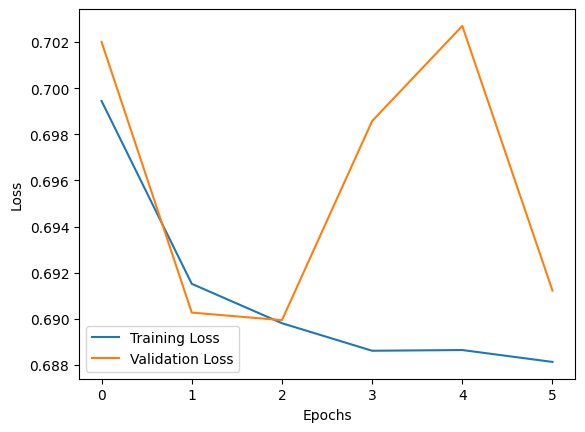

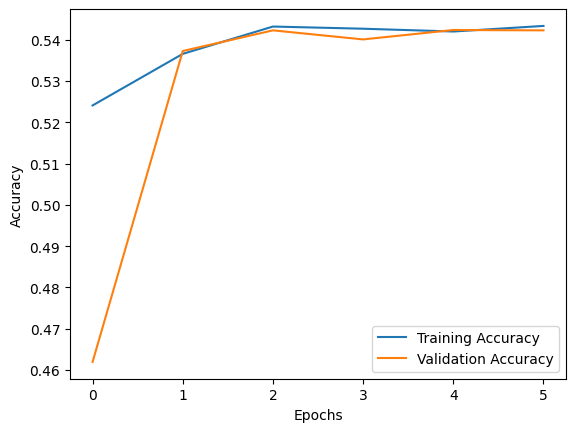

In [411]:
import matplotlib.pyplot as plt

# Plotting loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<h4> Evaluation of AI Model Performance </h4>

In [412]:
loss, accuracy = model.evaluate([X_test['redTeam_mapped'], X_test['blueTeam_mapped'], X_test_features], y_test)

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - accuracy: 0.5458 - loss: 0.6895


In [422]:
pred = model.predict([X_test['redTeam_mapped'], X_test['blueTeam_mapped'], X_test_features])
print(pred[0])

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
[0.5334399]


In [414]:
predicted_labels = (pred >= 0.52).astype(int)
df = pd.DataFrame(predicted_labels)

In [415]:
accuracy = accuracy_score(predicted_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.61


In [355]:
model.save('NeuralMatchUpAIModel.keras')

<h4>RandomForest</h4>

In [311]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [312]:
# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [313]:
# Make predictions
y_pred = rf_model.predict(X_test)

In [314]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5162733573120449
